<a href="https://colab.research.google.com/github/sriRuchitha/OIB-SIP/blob/main/Project_1_Proposal_Level_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# Run in Google Colab (Python 3)
!pip install -q kaggle xgboost prophet scikit-learn matplotlib pandas statsmodels

# If using Prophet: pip installs may print warnings; in Colab use
# !pip install -q prophet

# Mount Google Drive (optional, to save models/artifacts)
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# 1) Upload kaggle.json to /root/.kaggle/kaggle.json (or set via env)
# In Colab: from left pane -> Files -> Upload -> upload kaggle.json
!mkdir -p /root/.kaggle
!cp /content/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# 2) Download dataset (change dataset slug if needed)
!kaggle datasets download -d mohammadtalib786/retail-sales-dataset -p /content --unzip
# This will place CSV(s) in /content


cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [20]:
import os

for f in os.listdir('/content'):
    print(f)


.config
retail_sales_dataset (1).csv
drive
retail_sales_dataset (1) (1).csv
sample_data


In [22]:
import pandas as pd

df = pd.read_csv("/content/retail_sales_dataset (1).csv")
df.head()


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [24]:
df.columns


Index(['Transaction ID', 'Date', 'Customer ID', 'Gender', 'Age',
       'Product Category', 'Quantity', 'Price per Unit', 'Total Amount'],
      dtype='object')

In [26]:
import re

cols = df.columns
print("Columns:", cols.tolist())

# detect date column
date_candidates = [c for c in cols if re.search("date|time", c, re.IGNORECASE)]
print("Possible date columns:", date_candidates)

# detect numeric sales-like columns
sales_candidates = [c for c in cols if re.search("sale|amount|revenue|price|total", c, re.IGNORECASE)]
print("Possible sales columns:", sales_candidates)


Columns: ['Transaction ID', 'Date', 'Customer ID', 'Gender', 'Age', 'Product Category', 'Quantity', 'Price per Unit', 'Total Amount']
Possible date columns: ['Date']
Possible sales columns: ['Price per Unit', 'Total Amount']


In [28]:
# Inspect
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)
print("\nMissing counts:\n", df.isna().sum())

# Show first rows
display(df.head(8))

# Basic stats for numeric columns
display(df[['Quantity','Price per Unit','Total Amount']].describe().T)


Shape: (1000, 9)

Columns: ['Transaction ID', 'Date', 'Customer ID', 'Gender', 'Age', 'Product Category', 'Quantity', 'Price per Unit', 'Total Amount']

Dtypes:
 Transaction ID       int64
Date                object
Customer ID         object
Gender              object
Age                  int64
Product Category    object
Quantity             int64
Price per Unit       int64
Total Amount         int64
dtype: object

Missing counts:
 Transaction ID      0
Date                0
Customer ID         0
Gender              0
Age                 0
Product Category    0
Quantity            0
Price per Unit      0
Total Amount        0
dtype: int64


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100
5,6,2023-04-25,CUST006,Female,45,Beauty,1,30,30
6,7,2023-03-13,CUST007,Male,46,Clothing,2,25,50
7,8,2023-02-22,CUST008,Male,30,Electronics,4,25,100


,count,mean,std,min,25%,50%,75%,max
Quantity,1000.0,2.514,1.132734,1.0,1.0,3.0,4.0,4.0
Price per Unit,1000.0,179.890,189.681356,25.0,30.0,50.0,300.0,500.0
Total Amount,1000.0,456.000,559.997632,25.0,60.0,135.0,900.0,2000.0


In [29]:
# Ensure numeric columns are numeric
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Price per Unit'] = pd.to_numeric(df['Price per Unit'], errors='coerce')
df['Total Amount'] = pd.to_numeric(df['Total Amount'], errors='coerce')

# If Total Amount missing but Quantity and Price available, fill it
mask = df['Total Amount'].isna() & df['Quantity'].notna() & df['Price per Unit'].notna()
df.loc[mask, 'Total Amount'] = df.loc[mask, 'Quantity'] * df.loc[mask, 'Price per Unit']

# Drop rows still missing essential fields
df = df.dropna(subset=['Date','Total Amount']).reset_index(drop=True)

print("After cleaning shape:", df.shape)


After cleaning shape: (1000, 9)


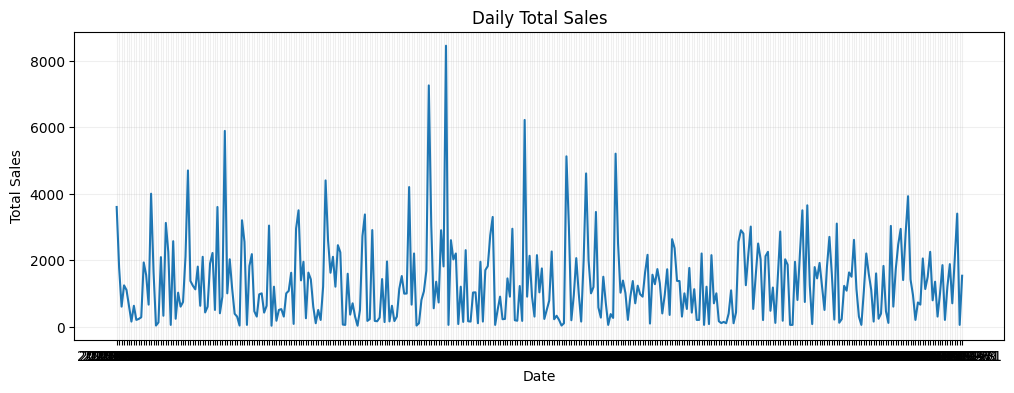

,Date,Total_Sales
0,2023-01-01,3600
1,2023-01-02,1765
2,2023-01-03,600
3,2023-01-04,1240
4,2023-01-05,1100


In [30]:
import matplotlib.pyplot as plt

# Aggregate to daily total sales
df_daily = df.groupby('Date', as_index=False)['Total Amount'].sum().rename(columns={'Total Amount':'Total_Sales'})
df_daily = df_daily.sort_values('Date').reset_index(drop=True)

# Quick plot
plt.figure(figsize=(12,4))
plt.plot(df_daily['Date'], df_daily['Total_Sales'])
plt.title('Daily Total Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(alpha=0.2)
plt.show()

# Show head
display(df_daily.head())


In [32]:
df_daily['Date'] = pd.to_datetime(df_daily['Date'], errors='coerce')


In [33]:
df_daily['year'] = df_daily['Date'].dt.year
df_daily['month'] = df_daily['Date'].dt.month
df_daily['day'] = df_daily['Date'].dt.day
df_daily['dayofweek'] = df_daily['Date'].dt.dayofweek
df_daily['is_weekend'] = df_daily['dayofweek'].isin([5,6]).astype(int)


In [34]:
df_daily.dtypes


,0
Date,datetime64[ns]
Total_Sales,int64
year,int32
month,int32
day,int32
dayofweek,int32
is_weekend,int64


In [35]:
# Ensure Date column is datetime
df_daily['Date'] = pd.to_datetime(df_daily['Date'], errors='coerce')

# Verify dtype
print(df_daily['Date'].dtype)

# Now create features
df_daily['year'] = df_daily['Date'].dt.year
df_daily['month'] = df_daily['Date'].dt.month
df_daily['day'] = df_daily['Date'].dt.day
df_daily['dayofweek'] = df_daily['Date'].dt.dayofweek
df_daily['is_weekend'] = df_daily['dayofweek'].isin([5,6]).astype(int)


datetime64[ns]


In [36]:
df_daily['year'] = df_daily['Date'].dt.year
df_daily['month'] = df_daily['Date'].dt.month
df_daily['day'] = df_daily['Date'].dt.day
df_daily['dayofweek'] = df_daily['Date'].dt.dayofweek
df_daily['is_weekend'] = df_daily['dayofweek'].isin([5,6]).astype(int)

df_daily.head()


,Date,Total_Sales,year,month,day,dayofweek,is_weekend
0,2023-01-01,3600,2023,1,1,6,1
1,2023-01-02,1765,2023,1,2,0,0
2,2023-01-03,600,2023,1,3,1,0
3,2023-01-04,1240,2023,1,4,2,0
4,2023-01-05,1100,2023,1,5,3,0


In [37]:
df_daily = df_daily.sort_values('Date')

df_daily['lag_1'] = df_daily['Total_Sales'].shift(1)
df_daily['lag_7'] = df_daily['Total_Sales'].shift(7)
df_daily['roll_7'] = df_daily['Total_Sales'].shift(1).rolling(7).mean()
df_daily['roll_30'] = df_daily['Total_Sales'].shift(1).rolling(30).mean()

df_daily = df_daily.dropna().reset_index(drop=True)

df_daily.tail()


,Date,Total_Sales,year,month,day,dayofweek,is_weekend,lag_1,lag_7,roll_7,roll_30
310,2023-12-27,700,2023,12,27,2,0,1880.0,1350.0,1111.428571,1379.166667
311,2023-12-28,2075,2023,12,28,3,0,700.0,300.0,1018.571429,1394.666667
312,2023-12-29,3400,2023,12,29,4,0,2075.0,1000.0,1272.142857,1450.833333
313,2023-12-31,50,2023,12,31,6,1,3400.0,1850.0,1615.000000,1503.333333
314,2024-01-01,1530,2024,1,1,0,0,50.0,200.0,1357.857143,1489.666667


In [38]:
from sklearn.model_selection import train_test_split

features = ['month','dayofweek','is_weekend','lag_1','lag_7','roll_7','roll_30']
target = 'Total_Sales'

X = df_daily[features]
y = df_daily[target]

split = int(0.80 * len(df_daily))

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
dates_test = df_daily['Date'].iloc[split:]

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 252
Test size: 63


In [40]:
RMSE = mean_squared_error(y_test, pred_test) ** 0.5


In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

MAE = mean_absolute_error(y_test, pred_test)
RMSE = mean_squared_error(y_test, pred_test) ** 0.5   # RMSE manually

print("MAE:", MAE)
print("RMSE:", RMSE)


MAE: 791.502777777778
RMSE: 969.338864615654


In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

MAE = mean_absolute_error(y_test, pred_test)
RMSE = mean_squared_error(y_test, pred_test) ** 0.5   # RMSE calculation

print("MAE:", MAE)
print("RMSE:", RMSE)


MAE: 791.502777777778
RMSE: 969.338864615654


In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

MAE = mean_absolute_error(y_test, pred_test)
RMSE = mean_squared_error(y_test, pred_test) ** 0.5
MAPE = np.mean(np.abs((y_test.values - pred_test) / np.maximum(1e-6, y_test.values))) * 100

print(f"MAE:  {MAE:.2f}")
print(f"RMSE: {RMSE:.2f}")
print(f"MAPE: {MAPE:.2f}%")


MAE:  791.50
RMSE: 969.34
MAPE: 254.55%


In [44]:
import pandas as pd

pred_df = pd.DataFrame({
    'Date': dates_test.values,
    'Actual': y_test.values,
    'Predicted': pred_test,
    'Error': y_test.values - pred_test
})
pred_df.to_csv('/content/rf_predictions_summary.csv', index=False)
print("Saved /content/rf_predictions_summary.csv")
pred_df.head()


Saved /content/rf_predictions_summary.csv


,Date,Actual,Predicted,Error
0,2023-10-29,1250,1565.800,-315.800
1,2023-10-30,75,1247.800,-1172.800
2,2023-10-31,1790,1621.825,168.175
3,2023-11-01,1450,1348.250,101.750
4,2023-11-02,1915,1342.400,572.600


In [45]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

X_all = X.reset_index(drop=True)
y_all = y.reset_index(drop=True)
tscv = TimeSeriesSplit(n_splits=5)

maes = []
fold = 1
for train_idx, val_idx in tscv.split(X_all):
    X_tr, X_val = X_all.iloc[train_idx], X_all.iloc[val_idx]
    y_tr, y_val = y_all.iloc[train_idx], y_all.iloc[val_idx]
    m = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    m.fit(X_tr, y_tr)
    p = m.predict(X_val)
    mae = mean_absolute_error(y_val, p)
    print(f"Fold {fold} MAE: {mae:.2f}")
    maes.append(mae)
    fold += 1

print("CV MAE mean:", np.mean(maes), "std:", np.std(maes))


Fold 1 MAE: 1237.56
Fold 2 MAE: 1034.52
Fold 3 MAE: 809.15
Fold 4 MAE: 1010.95
Fold 5 MAE: 833.47
CV MAE mean: 985.131346153846 std: 155.43151506709955


In [46]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import joblib

param_dist = {
    'n_estimators': [100, 200, 400],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': randint(2, 6),
    'min_samples_leaf': randint(1, 4)
}

# Use a small TimeSeriesSplit for CV inside RandomizedSearch
tscv_small = TimeSeriesSplit(n_splits=3)
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

rs = RandomizedSearchCV(
    rf_base, param_distributions=param_dist,
    n_iter=10, cv=tscv_small, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42
)

rs.fit(X_train, y_train)   # tune only on training portion to avoid leakage
print("Best params:", rs.best_params_)
print("Best CV MAE (neg):", rs.best_score_)

best_rf = rs.best_estimator_
# Save tuned model
joblib.dump(best_rf, "/content/best_rf_tuned.joblib")
print("Saved tuned model to /content/best_rf_tuned.joblib")


Best params: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 400}
Best CV MAE (neg): -1063.5348778583373
Saved tuned model to /content/best_rf_tuned.joblib


In [47]:
best_pred = best_rf.predict(X_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_best = mean_absolute_error(y_test, best_pred)
rmse_best = mean_squared_error(y_test, best_pred) ** 0.5
print(f"Tuned model MAE: {mae_best:.2f}  RMSE: {rmse_best:.2f}")


Tuned model MAE: 775.21  RMSE: 946.61


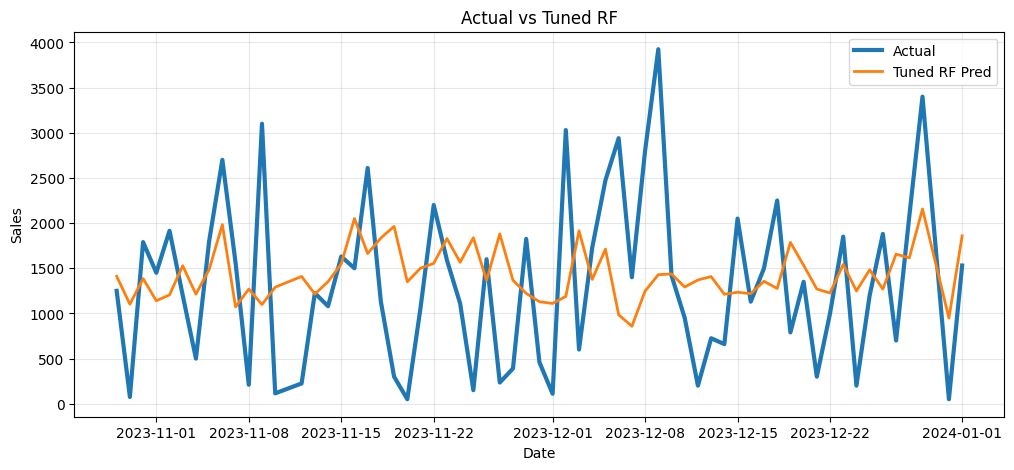

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(dates_test, y_test.values, label='Actual', linewidth=3)
plt.plot(dates_test, best_pred, label='Tuned RF Pred', linewidth=2)
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Actual vs Tuned RF')
plt.grid(alpha=0.3); plt.show()


In [49]:
# choose one or loop across all categories
categories = df['Product Category'].unique().tolist()
print("Categories found:", categories)

# Example: forecast for one category (change index or loop)
cat = categories[0]
df_cat = df[df['Product Category'] == cat].groupby('Date', as_index=False)['Total Amount'].sum().rename(columns={'Total Amount':'Total_Sales'}).sort_values('Date')
df_cat['Date'] = pd.to_datetime(df_cat['Date'])
# create lags
df_cat['lag_1'] = df_cat['Total_Sales'].shift(1)
df_cat['roll_7'] = df_cat['Total_Sales'].shift(1).rolling(7).mean()
df_cat = df_cat.dropna()

# quick train/test split
split = int(0.8 * len(df_cat))
Xc = df_cat[['lag_1','roll_7']]
yc = df_cat['Total_Sales']
Xc_train, Xc_test = Xc.iloc[:split], Xc.iloc[split:]
yc_train, yc_test = yc.iloc[:split], yc.iloc[split:]
from sklearn.ensemble import RandomForestRegressor
m_cat = RandomForestRegressor(n_estimators=100, random_state=42)
m_cat.fit(Xc_train, yc_train)
pc = m_cat.predict(Xc_test)
print(f"Category '{cat}' MAE:", mean_absolute_error(yc_test, pc))


Categories found: ['Beauty', 'Clothing', 'Electronics']
Category 'Beauty' MAE: 661.2837499999999


Second Dataset


In [66]:
# Run in Colab cell
!pip install pandas numpy matplotlib scikit-learn rapidfuzz streamlit pyngrok plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.5 MB/s eta 0:00:00


In [67]:
# Upload kaggle.json via Colab file upload widget, or place it in /content/.kaggle/kaggle.json
from google.colab import files
files.upload()  # select kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download McDonald's Nutrition Facts dataset
!kaggle datasets download -d mcdonalds/nutrition-facts -q
!unzip -q nutrition-facts.zip -d nutrition_data


Saving menu (1).csv to menu (1).csv
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open nutrition-facts.zip, nutrition-facts.zip.zip or nutrition-facts.zip.ZIP.


In [69]:
from google.colab import files
uploaded = files.upload()  # choose your menu CSV
import io
df_menu = pd.read_csv(io.BytesIO(next(iter(uploaded.values()))))


Saving menu (1).csv to menu (1) (1).csv


In [73]:
from google.colab import files
uploaded = files.upload()

import io
df_nutrition = pd.read_csv(io.BytesIO(next(iter(uploaded.values()))))
df_nutrition.head()


Saving menu (1).csv to menu (1) (2).csv


,Category,Item,Serving Size,Calories,Calories from Fat,Total Fat,Total Fat (% Daily Value),Saturated Fat,Saturated Fat (% Daily Value),Trans Fat,Cholesterol,Cholesterol (% Daily Value),Sodium,Sodium (% Daily Value),Carbohydrates,Carbohydrates (% Daily Value),Dietary Fiber,Dietary Fiber (% Daily Value),Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value)
0,Breakfast,Egg McMuffin,4.8 oz (136 g),300,120,13.0,20,5.0,25,0.0,260,87,750,31,31,10,4,17,3,17,10,0,25,15
1,Breakfast,Egg White Delight,4.8 oz (135 g),250,70,8.0,12,3.0,15,0.0,25,8,770,32,30,10,4,17,3,18,6,0,25,8
2,Breakfast,Sausage McMuffin,3.9 oz (111 g),370,200,23.0,35,8.0,42,0.0,45,15,780,33,29,10,4,17,2,14,8,0,25,10
3,Breakfast,Sausage McMuffin with Egg,5.7 oz (161 g),450,250,28.0,43,10.0,52,0.0,285,95,860,36,30,10,4,17,2,21,15,0,30,15
4,Breakfast,Sausage McMuffin with Egg Whites,5.7 oz (161 g),400,210,23.0,35,8.0,42,0.0,50,16,880,37,30,10,4,17,2,21,6,0,25,10


In [74]:
def clean_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("(", "")
        .str.replace(")", "")
    )
    return df

df_nut = clean_columns(df_nutrition)
df_menu = clean_columns(df_menu)


In [75]:
print(df_nut.head())
print(df_menu.head())

print(df_nut.columns)
print(df_menu.columns)


    category                              item    serving_size  calories  calories_from_fat  total_fat  total_fat_%_daily_value  saturated_fat  saturated_fat_%_daily_value  \
0  Breakfast                      Egg McMuffin  4.8 oz (136 g)       300                120       13.0                       20            5.0                           25   
1  Breakfast                 Egg White Delight  4.8 oz (135 g)       250                 70        8.0                       12            3.0                           15   
2  Breakfast                  Sausage McMuffin  3.9 oz (111 g)       370                200       23.0                       35            8.0                           42   
3  Breakfast         Sausage McMuffin with Egg  5.7 oz (161 g)       450                250       28.0                       43           10.0                           52   
4  Breakfast  Sausage McMuffin with Egg Whites  5.7 oz (161 g)       400                210       23.0                       

In [77]:
# replace df_menu with the actual variable you have (df_menu is assumed)
print("Columns in df_menu:", df_menu.columns.tolist())
print("\nFirst 5 rows of df_menu:")
display(df_menu.head())

# same for the nutrition dataframe
print("\nColumns in df_nut:", df_nut.columns.tolist())
print("\nFirst 5 rows of df_nut:")
display(df_nut.head())


Columns in df_menu: ['category', 'item', 'serving_size', 'calories', 'calories_from_fat', 'total_fat', 'total_fat_%_daily_value', 'saturated_fat', 'saturated_fat_%_daily_value', 'trans_fat', 'cholesterol', 'cholesterol_%_daily_value', 'sodium', 'sodium_%_daily_value', 'carbohydrates', 'carbohydrates_%_daily_value', 'dietary_fiber', 'dietary_fiber_%_daily_value', 'sugars', 'protein', 'vitamin_a_%_daily_value', 'vitamin_c_%_daily_value', 'calcium_%_daily_value', 'iron_%_daily_value']

First 5 rows of df_menu:


,category,item,serving_size,calories,calories_from_fat,total_fat,total_fat_%_daily_value,saturated_fat,saturated_fat_%_daily_value,trans_fat,cholesterol,cholesterol_%_daily_value,sodium,sodium_%_daily_value,carbohydrates,carbohydrates_%_daily_value,dietary_fiber,dietary_fiber_%_daily_value,sugars,protein,vitamin_a_%_daily_value,vitamin_c_%_daily_value,calcium_%_daily_value,iron_%_daily_value
0,Breakfast,Egg McMuffin,4.8 oz (136 g),300,120,13.0,20,5.0,25,0.0,260,87,750,31,31,10,4,17,3,17,10,0,25,15
1,Breakfast,Egg White Delight,4.8 oz (135 g),250,70,8.0,12,3.0,15,0.0,25,8,770,32,30,10,4,17,3,18,6,0,25,8
2,Breakfast,Sausage McMuffin,3.9 oz (111 g),370,200,23.0,35,8.0,42,0.0,45,15,780,33,29,10,4,17,2,14,8,0,25,10
3,Breakfast,Sausage McMuffin with Egg,5.7 oz (161 g),450,250,28.0,43,10.0,52,0.0,285,95,860,36,30,10,4,17,2,21,15,0,30,15
4,Breakfast,Sausage McMuffin with Egg Whites,5.7 oz (161 g),400,210,23.0,35,8.0,42,0.0,50,16,880,37,30,10,4,17,2,21,6,0,25,10



Columns in df_nut: ['category', 'item', 'serving_size', 'calories', 'calories_from_fat', 'total_fat', 'total_fat_%_daily_value', 'saturated_fat', 'saturated_fat_%_daily_value', 'trans_fat', 'cholesterol', 'cholesterol_%_daily_value', 'sodium', 'sodium_%_daily_value', 'carbohydrates', 'carbohydrates_%_daily_value', 'dietary_fiber', 'dietary_fiber_%_daily_value', 'sugars', 'protein', 'vitamin_a_%_daily_value', 'vitamin_c_%_daily_value', 'calcium_%_daily_value', 'iron_%_daily_value', 'item_clean']

First 5 rows of df_nut:


,category,item,serving_size,calories,calories_from_fat,total_fat,total_fat_%_daily_value,saturated_fat,saturated_fat_%_daily_value,trans_fat,cholesterol,cholesterol_%_daily_value,sodium,sodium_%_daily_value,carbohydrates,carbohydrates_%_daily_value,dietary_fiber,dietary_fiber_%_daily_value,sugars,protein,vitamin_a_%_daily_value,vitamin_c_%_daily_value,calcium_%_daily_value,iron_%_daily_value,item_clean
0,Breakfast,Egg McMuffin,4.8 oz (136 g),300,120,13.0,20,5.0,25,0.0,260,87,750,31,31,10,4,17,3,17,10,0,25,15,egg mcmuffin
1,Breakfast,Egg White Delight,4.8 oz (135 g),250,70,8.0,12,3.0,15,0.0,25,8,770,32,30,10,4,17,3,18,6,0,25,8,egg white delight
2,Breakfast,Sausage McMuffin,3.9 oz (111 g),370,200,23.0,35,8.0,42,0.0,45,15,780,33,29,10,4,17,2,14,8,0,25,10,sausage mcmuffin
3,Breakfast,Sausage McMuffin with Egg,5.7 oz (161 g),450,250,28.0,43,10.0,52,0.0,285,95,860,36,30,10,4,17,2,21,15,0,30,15,sausage mcmuffin with egg
4,Breakfast,Sausage McMuffin with Egg Whites,5.7 oz (161 g),400,210,23.0,35,8.0,42,0.0,50,16,880,37,30,10,4,17,2,21,6,0,25,10,sausage mcmuffin with egg whites


In [78]:
# Helper: choose a column from likely candidates
def choose_column(df, candidates):
    cols = df.columns.astype(str).tolist()
    for c in candidates:
        if c in cols:
            return c
    # fallback: pick the first string-like column (best-effort)
    for col in cols:
        if df[col].dtype == object:
            return col
    return None

# likely candidates - adjust if your dataset uses other names
menu_candidates = ['name','item','product_name','menu_item','title','product','food','dish']
nut_candidates  = ['item','name','food','product_name','menu_item','title']

menu_name_col = choose_column(df_menu, menu_candidates)
nut_name_col  = choose_column(df_nut, nut_candidates)

print("Detected menu name column:", menu_name_col)
print("Detected nutrition name column:", nut_name_col)

# create standardized columns
if menu_name_col is not None:
    df_menu = df_menu.copy()
    df_menu['name'] = df_menu[menu_name_col].astype(str)
else:
    raise KeyError("Couldn't detect a name-like column in df_menu. See df_menu.columns for options.")

if nut_name_col is not None:
    df_nut = df_nut.copy()
    df_nut['item'] = df_nut[nut_name_col].astype(str)
else:
    raise KeyError("Couldn't detect an item-like column in df_nut. See df_nut.columns for options.")

# quick check
print(df_menu[['name']].head())
print(df_nut[['item']].head())


Detected menu name column: item
Detected nutrition name column: item
                               name
0                      Egg McMuffin
1                 Egg White Delight
2                  Sausage McMuffin
3         Sausage McMuffin with Egg
4  Sausage McMuffin with Egg Whites
                               item
0                      Egg McMuffin
1                 Egg White Delight
2                  Sausage McMuffin
3         Sausage McMuffin with Egg
4  Sausage McMuffin with Egg Whites


In [79]:
# basic cleaning
import re
def normalize_text(s):
    if pd.isna(s): return ""
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)                  # collapse spaces
    s = re.sub(r'[^\w\s]', '', s)               # remove punctuation
    return s

df_menu['name_clean'] = df_menu['name'].apply(normalize_text)
df_nut['item_clean']  = df_nut['item'].apply(normalize_text)

# sanity
display(df_menu[['name','name_clean']].head())
display(df_nut[['item','item_clean']].head())


,name,name_clean
0,Egg McMuffin,egg mcmuffin
1,Egg White Delight,egg white delight
2,Sausage McMuffin,sausage mcmuffin
3,Sausage McMuffin with Egg,sausage mcmuffin with egg
4,Sausage McMuffin with Egg Whites,sausage mcmuffin with egg whites


,item,item_clean
0,Egg McMuffin,egg mcmuffin
1,Egg White Delight,egg white delight
2,Sausage McMuffin,sausage mcmuffin
3,Sausage McMuffin with Egg,sausage mcmuffin with egg
4,Sausage McMuffin with Egg Whites,sausage mcmuffin with egg whites


In [80]:
!pip install rapidfuzz -q


In [81]:
from rapidfuzz import process, fuzz
choices = df_nut['item_clean'].tolist()

def fuzzy_match_single(s, choices=choices, scorer=fuzz.WRatio, score_cutoff=60):
    if not s:
        return (None, 0)
    res = process.extractOne(s, choices, scorer=scorer)
    if res is None:
        return (None, 0)
    matched, score, _ = res
    if score < score_cutoff:
        return (None, score)  # low confidence; handle later
    return (matched, score)

# apply (this returns matched cleaned name)
matches = df_menu['name_clean'].apply(lambda x: fuzzy_match_single(x))
df_menu['matched_item_clean'] = matches.apply(lambda t: t[0])
df_menu['match_score'] = matches.apply(lambda t: t[1])

# Show low matches for manual review
display(df_menu[['name','name_clean','matched_item_clean','match_score']].sort_values('match_score').head(30))


,name,name_clean,matched_item_clean,match_score
255,McFlurry with Oreo Cookies (Small),mcflurry with oreo cookies small,mcflurry with oreo cookies small,100.0
254,McFlurry with M&M’s Candies (Snack),mcflurry with mms candies snack,mcflurry with mms candies snack,100.0
253,McFlurry with M&M’s Candies (Medium),mcflurry with mms candies medium,mcflurry with mms candies medium,100.0
252,McFlurry with M&M’s Candies (Small),mcflurry with mms candies small,mcflurry with mms candies small,100.0
251,Shamrock Shake (Large),shamrock shake large,shamrock shake large,100.0
250,Shamrock Shake (Medium),shamrock shake medium,shamrock shake medium,100.0
249,Chocolate Shake (Large),chocolate shake large,chocolate shake large,100.0
248,Chocolate Shake (Medium),chocolate shake medium,chocolate shake medium,100.0
247,Chocolate Shake (Small),chocolate shake small,chocolate shake small,100.0
246,Strawberry Shake (Large),strawberry shake large,strawberry shake large,100.0


In [83]:
# 1) Inspect df_merged columns and a few rows
print("df_merged columns:", df_merged.columns.tolist())
print("\nFirst 5 rows of df_merged:")
display(df_merged.head())

# 2) Helper: find a likely nutrition-name column inside df_merged
candidates = ['item','item_clean','name','name_clean','product_name','product','title','food','menu_item']
found = [c for c in candidates if c in df_merged.columns]
print("\nCandidate nutrition-name columns present in df_merged:", found)

# 3) If none of the expected nutrition-name columns are present, inspect df_nut and ensure item_clean exists
if not found:
    print("\nNo nutrition-name column found inside df_merged. Let's inspect df_nut for name-like columns and recreate the merge.")
    print("df_nut columns:", df_nut.columns.tolist())
    display(df_nut.head())

    # Try to detect a name-like column in df_nut
    nut_candidates = ['item','item_clean','name','product_name','title','food','menu_item']
    nut_name_col = None
    for c in nut_candidates:
        if c in df_nut.columns:
            nut_name_col = c
            break

    if nut_name_col is None:
        # fallback: choose first string column from df_nut
        for col in df_nut.columns:
            if df_nut[col].dtype == object:
                nut_name_col = col
                break

    print("Using df_nut column for merging:", nut_name_col)

    # Ensure df_nut has item_clean
    import re
    def normalize_text(s):
        if pd.isna(s): return ""
        s = str(s).lower().strip()
        s = re.sub(r'\s+', ' ', s)
        s = re.sub(r'[^\w\s]', '', s)
        return s

    if 'item_clean' not in df_nut.columns:
        df_nut['item_clean'] = df_nut[nut_name_col].astype(str).apply(normalize_text)
    if 'matched_item_clean' not in df_menu.columns:
        # recreate matched_item_clean from name_clean (if exists) otherwise create name_clean first
        if 'name_clean' not in df_menu.columns:
            # detect menu name column and create name_clean
            menu_name_col = None
            for c in ['name','product_name','title','menu_item','item']:
                if c in df_menu.columns:
                    menu_name_col = c
                    break
            if menu_name_col is None:
                # fallback to first string column
                for col in df_menu.columns:
                    if df_menu[col].dtype == object:
                        menu_name_col = col
                        break
            df_menu['name'] = df_menu[menu_name_col].astype(str)
            df_menu['name_clean'] = df_menu['name'].apply(normalize_text)
        # If matched_item_clean not present, set to name_clean so we can attempt exact merge (you may rematch later)
        df_menu['matched_item_clean'] = df_menu['name_clean']

    # Recreate df_merged by merging on cleaned names
    df_merged = df_menu.merge(df_nut, left_on='matched_item_clean', right_on='item_clean', how='left', suffixes=('_menu','_nut'))
    print("\nRe-created df_merged. Columns now:", df_merged.columns.tolist())
    display(df_merged.head())

    # update found list
    found = [c for c in candidates if c in df_merged.columns]
    print("\nNow detected nutrition-name columns in df_merged:", found)

# 4) Choose a nutrition-name column to display (prefer item or item_clean)
preferred = None
for c in ['item','item_clean','name','name_clean','product_name','food']:
    if c in df_merged.columns:
        preferred = c
        break

# 5) Safely display the expected preview using available columns
cols_to_show = ['name','matched_item_clean','match_score']
# only include preferred nutrition column if available and not duplicate of matched_item_clean
if preferred and preferred not in cols_to_show:
    cols_to_show.append(preferred)

print("\nDisplaying columns (only those that exist):", cols_to_show)
available = [c for c in cols_to_show if c in df_merged.columns]
display(df_merged[available].head(30))

# 6) Report rows where nutrition info is missing (based on the detected nutrition column)
if preferred and preferred in df_merged.columns:
    missing = df_merged[df_merged[preferred].isna()]
    print(f"\nRows with missing nutrition info (based on column '{preferred}'): {len(missing)}")
    display(missing[['name','matched_item_clean','match_score']].head(30))
else:
    print("\nCould not determine a nutrition column to test for missing values. Inspect df_merged above.")


df_merged columns: ['category_menu', 'item_menu', 'serving_size_menu', 'calories_menu', 'calories_from_fat_menu', 'total_fat_menu', 'total_fat_%_daily_value_menu', 'saturated_fat_menu', 'saturated_fat_%_daily_value_menu', 'trans_fat_menu', 'cholesterol_menu', 'cholesterol_%_daily_value_menu', 'sodium_menu', 'sodium_%_daily_value_menu', 'carbohydrates_menu', 'carbohydrates_%_daily_value_menu', 'dietary_fiber_menu', 'dietary_fiber_%_daily_value_menu', 'sugars_menu', 'protein_menu', 'vitamin_a_%_daily_value_menu', 'vitamin_c_%_daily_value_menu', 'calcium_%_daily_value_menu', 'iron_%_daily_value_menu', 'name', 'name_clean', 'matched_item_clean', 'match_score', 'category_nut', 'item_nut', 'serving_size_nut', 'calories_nut', 'calories_from_fat_nut', 'total_fat_nut', 'total_fat_%_daily_value_nut', 'saturated_fat_nut', 'saturated_fat_%_daily_value_nut', 'trans_fat_nut', 'cholesterol_nut', 'cholesterol_%_daily_value_nut', 'sodium_nut', 'sodium_%_daily_value_nut', 'carbohydrates_nut', 'carbohydr

,category_menu,item_menu,serving_size_menu,calories_menu,calories_from_fat_menu,total_fat_menu,total_fat_%_daily_value_menu,saturated_fat_menu,saturated_fat_%_daily_value_menu,trans_fat_menu,cholesterol_menu,cholesterol_%_daily_value_menu,sodium_menu,sodium_%_daily_value_menu,carbohydrates_menu,carbohydrates_%_daily_value_menu,dietary_fiber_menu,dietary_fiber_%_daily_value_menu,sugars_menu,protein_menu,vitamin_a_%_daily_value_menu,vitamin_c_%_daily_value_menu,calcium_%_daily_value_menu,iron_%_daily_value_menu,name,name_clean,matched_item_clean,match_score,category_nut,item_nut,serving_size_nut,calories_nut,calories_from_fat_nut,total_fat_nut,total_fat_%_daily_value_nut,saturated_fat_nut,saturated_fat_%_daily_value_nut,trans_fat_nut,cholesterol_nut,cholesterol_%_daily_value_nut,sodium_nut,sodium_%_daily_value_nut,carbohydrates_nut,carbohydrates_%_daily_value_nut,dietary_fiber_nut,dietary_fiber_%_daily_value_nut,sugars_nut,protein_nut,vitamin_a_%_daily_value_nut,vitamin_c_%_daily_value_nut,calcium_%_daily_value_nut,iron_%_daily_value_nut,item_clean
0,Breakfast,Egg McMuffin,4.8 oz (136 g),300,120,13.0,20,5.0,25,0.0,260,87,750,31,31,10,4,17,3,17,10,0,25,15,Egg McMuffin,egg mcmuffin,egg mcmuffin,100.0,Breakfast,Egg McMuffin,4.8 oz (136 g),300,120,13.0,20,5.0,25,0.0,260,87,750,31,31,10,4,17,3,17,10,0,25,15,egg mcmuffin
1,Breakfast,Egg White Delight,4.8 oz (135 g),250,70,8.0,12,3.0,15,0.0,25,8,770,32,30,10,4,17,3,18,6,0,25,8,Egg White Delight,egg white delight,egg white delight,100.0,Breakfast,Egg White Delight,4.8 oz (135 g),250,70,8.0,12,3.0,15,0.0,25,8,770,32,30,10,4,17,3,18,6,0,25,8,egg white delight
2,Breakfast,Sausage McMuffin,3.9 oz (111 g),370,200,23.0,35,8.0,42,0.0,45,15,780,33,29,10,4,17,2,14,8,0,25,10,Sausage McMuffin,sausage mcmuffin,sausage mcmuffin,100.0,Breakfast,Sausage McMuffin,3.9 oz (111 g),370,200,23.0,35,8.0,42,0.0,45,15,780,33,29,10,4,17,2,14,8,0,25,10,sausage mcmuffin
3,Breakfast,Sausage McMuffin with Egg,5.7 oz (161 g),450,250,28.0,43,10.0,52,0.0,285,95,860,36,30,10,4,17,2,21,15,0,30,15,Sausage McMuffin with Egg,sausage mcmuffin with egg,sausage mcmuffin with egg,100.0,Breakfast,Sausage McMuffin with Egg,5.7 oz (161 g),450,250,28.0,43,10.0,52,0.0,285,95,860,36,30,10,4,17,2,21,15,0,30,15,sausage mcmuffin with egg
4,Breakfast,Sausage McMuffin with Egg Whites,5.7 oz (161 g),400,210,23.0,35,8.0,42,0.0,50,16,880,37,30,10,4,17,2,21,6,0,25,10,Sausage McMuffin with Egg Whites,sausage mcmuffin with egg whites,sausage mcmuffin with egg whites,100.0,Breakfast,Sausage McMuffin with Egg Whites,5.7 oz (161 g),400,210,23.0,35,8.0,42,0.0,50,16,880,37,30,10,4,17,2,21,6,0,25,10,sausage mcmuffin with egg whites



Candidate nutrition-name columns present in df_merged: ['item_clean', 'name', 'name_clean']

Displaying columns (only those that exist): ['name', 'matched_item_clean', 'match_score', 'item_clean']


,name,matched_item_clean,match_score,item_clean
0,Egg McMuffin,egg mcmuffin,100.0,egg mcmuffin
1,Egg White Delight,egg white delight,100.0,egg white delight
2,Sausage McMuffin,sausage mcmuffin,100.0,sausage mcmuffin
3,Sausage McMuffin with Egg,sausage mcmuffin with egg,100.0,sausage mcmuffin with egg
4,Sausage McMuffin with Egg Whites,sausage mcmuffin with egg whites,100.0,sausage mcmuffin with egg whites
5,Steak & Egg McMuffin,steak egg mcmuffin,100.0,steak egg mcmuffin
6,"Bacon, Egg & Cheese Biscuit (Regular Biscuit)",bacon egg cheese biscuit regular biscuit,100.0,bacon egg cheese biscuit regular biscuit
7,"Bacon, Egg & Cheese Biscuit (Large Biscuit)",bacon egg cheese biscuit large biscuit,100.0,bacon egg cheese biscuit large biscuit
8,"Bacon, Egg & Cheese Biscuit with Egg Whites (R...",bacon egg cheese biscuit with egg whites regu...,100.0,bacon egg cheese biscuit with egg whites regu...
9,"Bacon, Egg & Cheese Biscuit with Egg Whites (L...",bacon egg cheese biscuit with egg whites larg...,100.0,bacon egg cheese biscuit with egg whites larg...



Rows with missing nutrition info (based on column 'item_clean'): 0


,name,matched_item_clean,match_score


In [84]:
import pandas as pd
import numpy as np

possible_nutr_columns = [
    'calories','energy','total_fat','fat',
    'saturated_fat','trans_fat','cholesterol','sodium',
    'carbohydrates','carbs','sugar','protein'
]

nutr_cols = [c for c in possible_nutr_columns if c in df_merged.columns]
print("Nutrition columns found:", nutr_cols)

for col in nutr_cols:
    df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce')

# fill missing values using median
df_merged[nutr_cols] = df_merged[nutr_cols].fillna(df_merged[nutr_cols].median())


Nutrition columns found: []


In [85]:
import matplotlib.pyplot as plt

if 'calories' in df_merged.columns:
    plt.hist(df_merged['calories'], bins=35)
    plt.title("Calories Distribution")
    plt.xlabel("Calories")
    plt.ylabel("Count")
    plt.show()
else:
    print("No calories column found.")


No calories column found.


In [87]:
# Robust nutrition-feature detection -> fill -> scale
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1) candidate names we expect
possible_nutr_columns = [
    'calories','energy','kcal','total_fat','fat','saturated_fat','trans_fat',
    'cholesterol','sodium','salt','carbohydrates','carbs','sugar','protein','fiber'
]

# 2) find exact/intersect columns (case-insensitive)
cols_lower = {c.lower(): c for c in df_merged.columns}
nutr_cols = []
for cand in possible_nutr_columns:
    if cand in cols_lower:
        nutr_cols.append(cols_lower[cand])

# 3) if none found, try fuzzy by keyword containment
if not nutr_cols:
    for col in df_merged.columns:
        col_l = col.lower()
        for k in ['calor','fat','saturat','sodium','salt','carb','sugar','protein','cholest','energy','kcal','fiber']:
            if k in col_l and col not in nutr_cols:
                nutr_cols.append(col)

# 4) if still none, try numeric columns and filter out obvious non-nutrition ones
if not nutr_cols:
    numeric_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()
    # filter out obvious non-nutrition numeric columns
    blacklist = {'price','quantity','qty','id','index','match_score','cluster','rank'}
    nutr_cols = [c for c in numeric_cols if c.lower() not in blacklist]

# 5) Final check & debug output
print("Detected nutrition-like columns:", nutr_cols)

if not nutr_cols:
    print("\nERROR: No nutrition columns detected. Please inspect df_merged columns below and either:")
    print(" - Rename your nutrition columns to common names (calories, protein, sugar, sodium, carbohydrates, total_fat),")
    print(" - Or tell me which columns contain nutrition values so I can adapt the code.")
    print("\ndf_merged columns:")
    print(df_merged.columns.tolist())
    print("\nPreview rows:")
    display(df_merged.head(6))
    raise ValueError("No nutrition columns found - see printed df_merged.columns for manual mapping.")

# 6) Convert to numeric, fill missing
for col in nutr_cols:
    df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce')

# If columns are all NaN for some reason, fill with 0 or median (choose median here)
df_merged[nutr_cols] = df_merged[nutr_cols].fillna(df_merged[nutr_cols].median())

# 7) Scale
scaled_cols = [f"scaled_{c}" for c in nutr_cols]
scaler = StandardScaler()
X = scaler.fit_transform(df_merged[nutr_cols].values)
df_merged[scaled_cols] = X

print("\nScaled columns created:", scaled_cols)
print("Shape of feature matrix X:", X.shape)
# Quick sanity checks
display(df_merged[[*nutr_cols, *scaled_cols]].head(5))


Detected nutrition-like columns: ['calories_menu', 'calories_from_fat_menu', 'total_fat_menu', 'total_fat_%_daily_value_menu', 'saturated_fat_menu', 'saturated_fat_%_daily_value_menu', 'trans_fat_menu', 'cholesterol_menu', 'cholesterol_%_daily_value_menu', 'sodium_menu', 'sodium_%_daily_value_menu', 'carbohydrates_menu', 'carbohydrates_%_daily_value_menu', 'dietary_fiber_menu', 'dietary_fiber_%_daily_value_menu', 'sugars_menu', 'protein_menu', 'calories_nut', 'calories_from_fat_nut', 'total_fat_nut', 'total_fat_%_daily_value_nut', 'saturated_fat_nut', 'saturated_fat_%_daily_value_nut', 'trans_fat_nut', 'cholesterol_nut', 'cholesterol_%_daily_value_nut', 'sodium_nut', 'sodium_%_daily_value_nut', 'carbohydrates_nut', 'carbohydrates_%_daily_value_nut', 'dietary_fiber_nut', 'dietary_fiber_%_daily_value_nut', 'sugars_nut', 'protein_nut']

Scaled columns created: ['scaled_calories_menu', 'scaled_calories_from_fat_menu', 'scaled_total_fat_menu', 'scaled_total_fat_%_daily_value_menu', 'scaled_

,calories_menu,calories_from_fat_menu,total_fat_menu,total_fat_%_daily_value_menu,saturated_fat_menu,saturated_fat_%_daily_value_menu,trans_fat_menu,cholesterol_menu,cholesterol_%_daily_value_menu,sodium_menu,sodium_%_daily_value_menu,carbohydrates_menu,carbohydrates_%_daily_value_menu,dietary_fiber_menu,dietary_fiber_%_daily_value_menu,sugars_menu,protein_menu,calories_nut,calories_from_fat_nut,total_fat_nut,total_fat_%_daily_value_nut,saturated_fat_nut,saturated_fat_%_daily_value_nut,trans_fat_nut,cholesterol_nut,cholesterol_%_daily_value_nut,sodium_nut,sodium_%_daily_value_nut,carbohydrates_nut,carbohydrates_%_daily_value_nut,dietary_fiber_nut,dietary_fiber_%_daily_value_nut,sugars_nut,protein_nut,scaled_calories_menu,scaled_calories_from_fat_menu,scaled_total_fat_menu,scaled_total_fat_%_daily_value_menu,scaled_saturated_fat_menu,scaled_saturated_fat_%_daily_value_menu,scaled_trans_fat_menu,scaled_cholesterol_menu,scaled_cholesterol_%_daily_value_menu,scaled_sodium_menu,scaled_sodium_%_daily_value_menu,scaled_carbohydrates_menu,scaled_carbohydrates_%_daily_value_menu,scaled_dietary_fiber_menu,scaled_dietary_fiber_%_daily_value_menu,scaled_sugars_menu,scaled_protein_menu,scaled_calories_nut,scaled_calories_from_fat_nut,scaled_total_fat_nut,scaled_total_fat_%_daily_value_nut,scaled_saturated_fat_nut,scaled_saturated_fat_%_daily_value_nut,scaled_trans_fat_nut,scaled_cholesterol_nut,scaled_cholesterol_%_daily_value_nut,scaled_sodium_nut,scaled_sodium_%_daily_value_nut,scaled_carbohydrates_nut,scaled_carbohydrates_%_daily_value_nut,scaled_dietary_fiber_nut,scaled_dietary_fiber_%_daily_value_nut,scaled_sugars_nut,scaled_protein_nut
0,300,120,13.0,20,5.0,25,0.0,260,87,750,31,31,10,4,17,3,17,300,120,13.0,20,5.0,25,0.0,260,87,750,31,31,10,4,17,3,17,-0.284684,-0.055600,-0.082193,-0.083110,-0.189714,-0.186753,-0.475935,2.354245,2.362878,0.441471,0.430331,-0.579695,-0.614883,1.514176,1.663125,-0.923090,0.321071,-0.284684,-0.055600,-0.082193,-0.083110,-0.189714,-0.186753,-0.475935,2.354245,2.362878,0.441471,0.430331,-0.579695,-0.614883,1.514176,1.663125,-0.923090,0.321071
1,250,70,8.0,12,3.0,15,0.0,25,8,770,32,30,10,4,17,3,18,250,70,8.0,12,3.0,15,0.0,25,8,770,32,30,10,4,17,3,18,-0.493184,-0.447358,-0.434836,-0.449359,-0.566247,-0.562864,-0.475935,-0.343764,-0.357915,0.476198,0.472017,-0.615159,-0.614883,1.514176,1.663125,-0.923090,0.408758,-0.493184,-0.447358,-0.434836,-0.449359,-0.566247,-0.562864,-0.475935,-0.343764,-0.357915,0.476198,0.472017,-0.615159,-0.614883,1.514176,1.663125,-0.923090,0.408758
2,370,200,23.0,35,8.0,42,0.0,45,15,780,33,29,10,4,17,2,14,370,200,23.0,35,8.0,42,0.0,45,15,780,33,29,10,4,17,2,14,0.007217,0.571214,0.623093,0.603606,0.375084,0.452635,-0.475935,-0.114147,-0.116832,0.493562,0.513704,-0.650622,-0.614883,1.514176,1.663125,-0.958025,0.058009,0.007217,0.571214,0.623093,0.603606,0.375084,0.452635,-0.475935,-0.114147,-0.116832,0.493562,0.513704,-0.650622,-0.614883,1.514176,1.663125,-0.958025,0.058009
3,450,250,28.0,43,10.0,52,0.0,285,95,860,36,30,10,4,17,2,21,450,250,28.0,43,10.0,52,0.0,285,95,860,36,30,10,4,17,2,21,0.340818,0.962972,0.975736,0.969855,0.751616,0.828745,-0.475935,2.641267,2.638401,0.632471,0.638763,-0.615159,-0.614883,1.514176,1.663125,-0.958025,0.671820,0.340818,0.962972,0.975736,0.969855,0.751616,0.828745,-0.475935,2.641267,2.638401,0.632471,0.638763,-0.615159,-0.614883,1.514176,1.663125,-0.958025,0.671820
4,400,210,23.0,35,8.0,42,0.0,50,16,880,37,30,10,4,17,2,21,400,210,23.0,35,8.0,42,0.0,50,16,880,37,30,10,4,17,2,21,0.132318,0.649565,0.623093,0.603606,0.375084,0.452635,-0.475935,-0.056742,-0.082392,0.667198,0.680449,-0.615159,-0.614883,1.514176,1.663125,-0.958025,0.671820,0.132318,0.649565,0.623093,0.603606,0.375084,0.452635,-0.475935,-0.056742,-0.082392,0.667198,0.680449,-0.615159,-0.614883,1.514176,1.663125,-0.958025,0.671820


In [88]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Compute similarity matrix
sim_matrix = cosine_similarity(X)
print("Similarity matrix shape:", sim_matrix.shape)


Similarity matrix shape: (260, 260)


In [89]:
def recommend_item(item_name, top_n=5):
    name_clean = item_name.lower().strip()

    # find matching index
    idx_list = df_merged.index[df_merged['name_clean'] == name_clean].tolist()

    if not idx_list:
        return f"Item '{item_name}' not found in menu."

    idx = idx_list[0]

    sims = sim_matrix[idx]
    top_idx = np.argsort(sims)[::-1][1:top_n+1]

    return df_merged.iloc[top_idx][['name','calories','protein','sodium']]


In [90]:
df_merged['name'].head(20)   # to view names


,name
0,Egg McMuffin
1,Egg White Delight
2,Sausage McMuffin
3,Sausage McMuffin with Egg
4,Sausage McMuffin with Egg Whites
5,Steak & Egg McMuffin
6,"Bacon, Egg & Cheese Biscuit (Regular Biscuit)"
7,"Bacon, Egg & Cheese Biscuit (Large Biscuit)"
8,"Bacon, Egg & Cheese Biscuit with Egg Whites (R..."
9,"Bacon, Egg & Cheese Biscuit with Egg Whites (L..."


In [92]:
from sklearn.cluster import KMeans

k = 4   # you can change to 3, 4, 5, etc.
kmeans = KMeans(n_clusters=k, random_state=42)
df_merged['cluster'] = kmeans.fit_predict(X)

print(df_merged['cluster'].value_counts())



Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x78ca0ee1c860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.12/dist-packages/numpy.libs/libscipy_openblas64_-99b71e

cluster
1    148
0     71
3     31
2     10
Name: count, dtype: int64


In [93]:
def filter_menu(max_cal=None, min_protein=None, max_sodium=None, cluster=None):
    df = df_merged.copy()

    if max_cal is not None:
        df = df[df['calories'] <= max_cal]

    if min_protein is not None:
        df = df[df['protein'] >= min_protein]

    if max_sodium is not None:
        df = df[df['sodium'] <= max_sodium]

    if cluster is not None:
        df = df[df['cluster'] == cluster]

    return df[['name','calories','protein','sodium','cluster']]


In [94]:
df_merged.to_csv("processed_menu_dataset.csv", index=False)
print("Exported file: processed_menu_dataset.csv")


Exported file: processed_menu_dataset.csv
